<a href="https://colab.research.google.com/github/NagaShivani6/BharatIntern-Tasks/blob/main/SMS_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Reading the data
df = pd.read_csv('/content/spam.csv',encoding='latin-1')

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


<ipython-input-4-9d5947cbf609>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label'],palette={"ham":"blue","spam":"red"})


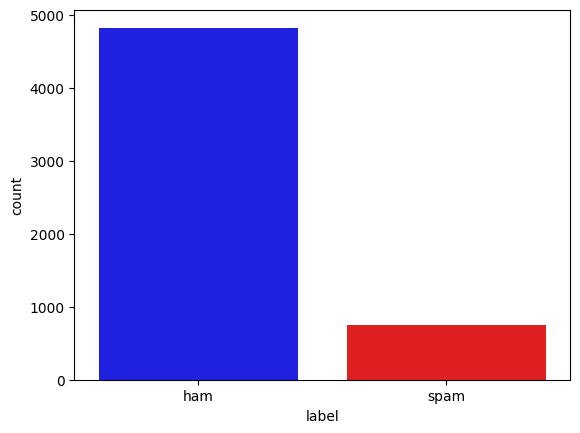

In [4]:
sns.countplot(x=df['label'],palette={"ham":"blue","spam":"red"})
plt.show()

In [5]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

15


In [6]:
#Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15585


In [7]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))

In [8]:
#Building the models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()

In [9]:
#Performance of baseline model
nb_accuracy=accuracy_score(y_test,baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test,baseline_model.predict(X_test_vec)))

0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



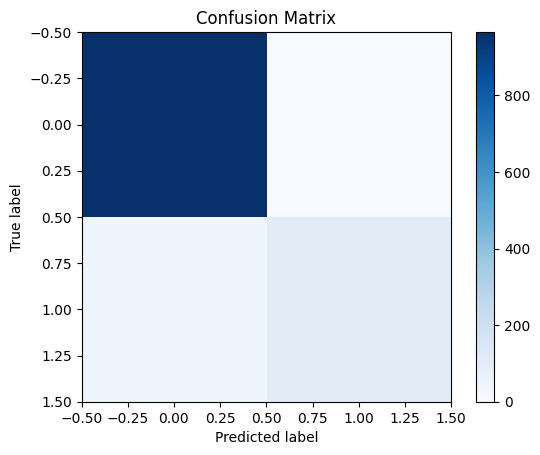

In [10]:
#Confusion matrix for the baseline model
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, baseline_model.predict(X_test_vec))

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [11]:
#we’ll create a custom text vectorization layer using TensorFlow.
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)

In [12]:
#Output of a sample sentence using text vectorization
sample_sentence='This is a message'
text_vec([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [13]:
#let’s create an embedding layer
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN)

In [14]:
#let’s build and compile model 1 using the Tensorflow Functional API
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])

In [15]:
# Summary of the model 1
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128  

In [16]:
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [17]:
#Training the model-1
history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), validation_steps=int(0.2 * len(X_test)))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


140/140 [==============================] - 6s 33ms/step - loss: 0.0000e+00 - accuracy: 0.8625 - val_loss: 0.0000e+00 - val_accuracy: 0.8655
Epoch 2/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0000e+00 - accuracy: 0.8661 - val_loss: 0.0000e+00 - val_accuracy: 0.8655
Epoch 3/5
140/140 [==============================] - 4s 29ms/step - loss: 0.0000e+00 - accuracy: 0.8661 - val_loss: 0.0000e+00 - val_accuracy: 0.8655
Epoch 4/5
140/140 [==============================] - 4s 28ms/step - loss: 0.0000e+00 - accuracy: 0.8661 - val_loss: 0.0000e+00 - val_accuracy: 0.8655
Epoch 5/5
140/140 [==============================] - 5s 35ms/step - loss: 0.0000e+00 - accuracy: 0.8661 - val_loss: 0.0000e+00 - val_accuracy: 0.8655


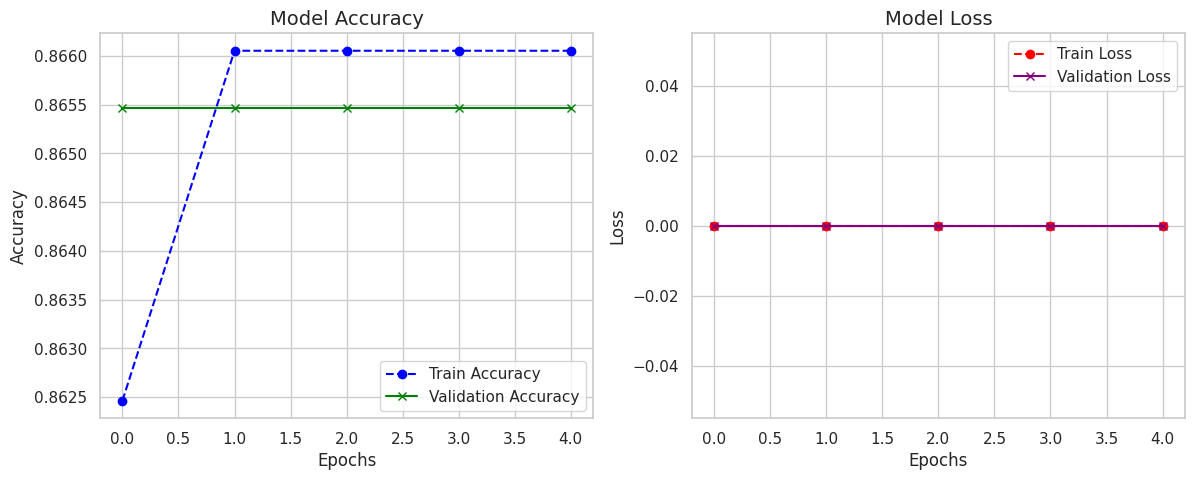

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot accuracy and loss over epochs with improved colors
def plot_history(history):
    sns.set(style="whitegrid")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linestyle='--', marker='o')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', linestyle='-', marker='x')
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Train Loss', color='red', linestyle='--', marker='o')
    ax2.plot(history.history['val_loss'], label='Validation Loss', color='purple', linestyle='-', marker='x')
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    plt.show()

# Call the function with the training history
plot_history(history_1)


In [19]:
#Let’s create helper functions for compiling, fitting, and evaluating the model performance.
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
              X_test=X_test, y_test=y_test):
    '''
    fit the model with given epochs, train
    and test data
    '''
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        validation_steps=int(0.2*len(X_test)))
    return history

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                          'precision': precision,
                          'recall': recall,
                          'f1-score': f1}

    return model_results_dict